# Task I.1: Exploratory data analysis

Initializing a Spark session

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Movie_recommendation").config("spark.some.config.option","some-value").getOrCreate()

The datasets can be easily downloaded from these links: 
1. 'rating.csv': https://www.kaggle.com/rounakbanik/the-movies-dataset?select=ratings_small.csv
2. 'movies.csv': https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv
        
Number of rows and columns:

In [2]:
rating = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r"C:\Users\74108\Downloads\ratings.csv")
rating = rating.drop('timestamp')

movies = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r"C:\Users\74108\Downloads\movies.csv")
movie_data = rating.join(movies, on='movieId')

Columns = len(movie_data.columns)
Rows = movie_data.count()
print('Number of Columns: {}\nNumber of Rows: {}'.format(Columns, Rows))
movie_data.columns

Number of Columns: 10
Number of Rows: 100836


['movieId',
 'userId',
 'rating',
 'vote_average',
 'vote_count',
 'revenue',
 'budget',
 'adult',
 'title',
 'genres']

DATA CLEANING: Replace all the zeros in the abaove mentioned fields (except “Pregnancies”) with NaN.

In [3]:
import numpy as np
from pyspark.sql.functions import when

movie_data = movie_data.withColumn("userId",when(movie_data.userId==0,np.nan).otherwise(movie_data.userId))
movie_data = movie_data.withColumn("movieId",when(movie_data.movieId==0,np.nan).otherwise(movie_data.movieId))
movie_data = movie_data.withColumn("rating",when(movie_data.rating==0,np.nan).otherwise(movie_data.rating))
movie_data = movie_data.withColumn("title",when(movie_data.title==0,np.nan).otherwise(movie_data.title))
from pyspark.sql.types import IntegerType
movie_data = movie_data.withColumn("budget", movie_data["budget"].cast(IntegerType()))

movie_data.show()

+-------+------+------+------------+----------+---------+--------+-----+--------------------+--------------------+
|movieId|userId|rating|vote_average|vote_count|  revenue|  budget|adult|               title|              genres|
+-------+------+------+------------+----------+---------+--------+-----+--------------------+--------------------+
|    1.0|   1.0|   4.0|         7.7|      5415|373554033|30000000|FALSE|    Toy Story (1995)|Adventure|Animati...|
|    3.0|   1.0|   4.0|         6.5|        92|        0|       0|FALSE|Grumpier Old Men ...|      Comedy|Romance|
|    6.0|   1.0|   4.0|         7.7|      1886|187436818|60000000|FALSE|         Heat (1995)|Action|Crime|Thri...|
|   47.0|   1.0|   5.0|         5.4|       452|122195920|18000000|FALSE|Seven (a.k.a. Se7...|    Mystery|Thriller|
|   50.0|   1.0|   5.0|         8.1|      5915|327311859|33000000|FALSE|Usual Suspects, T...|Crime|Mystery|Thr...|
|   70.0|   1.0|   3.0|         6.2|       192|        0|       0|FALSE|From Dus

Correlations between independent variables using data visualization.
Selecting different numeric and string columns, and drawing 1 plot (e.g. bar chart, histogram, boxplot, etc.)
for each to summarise it


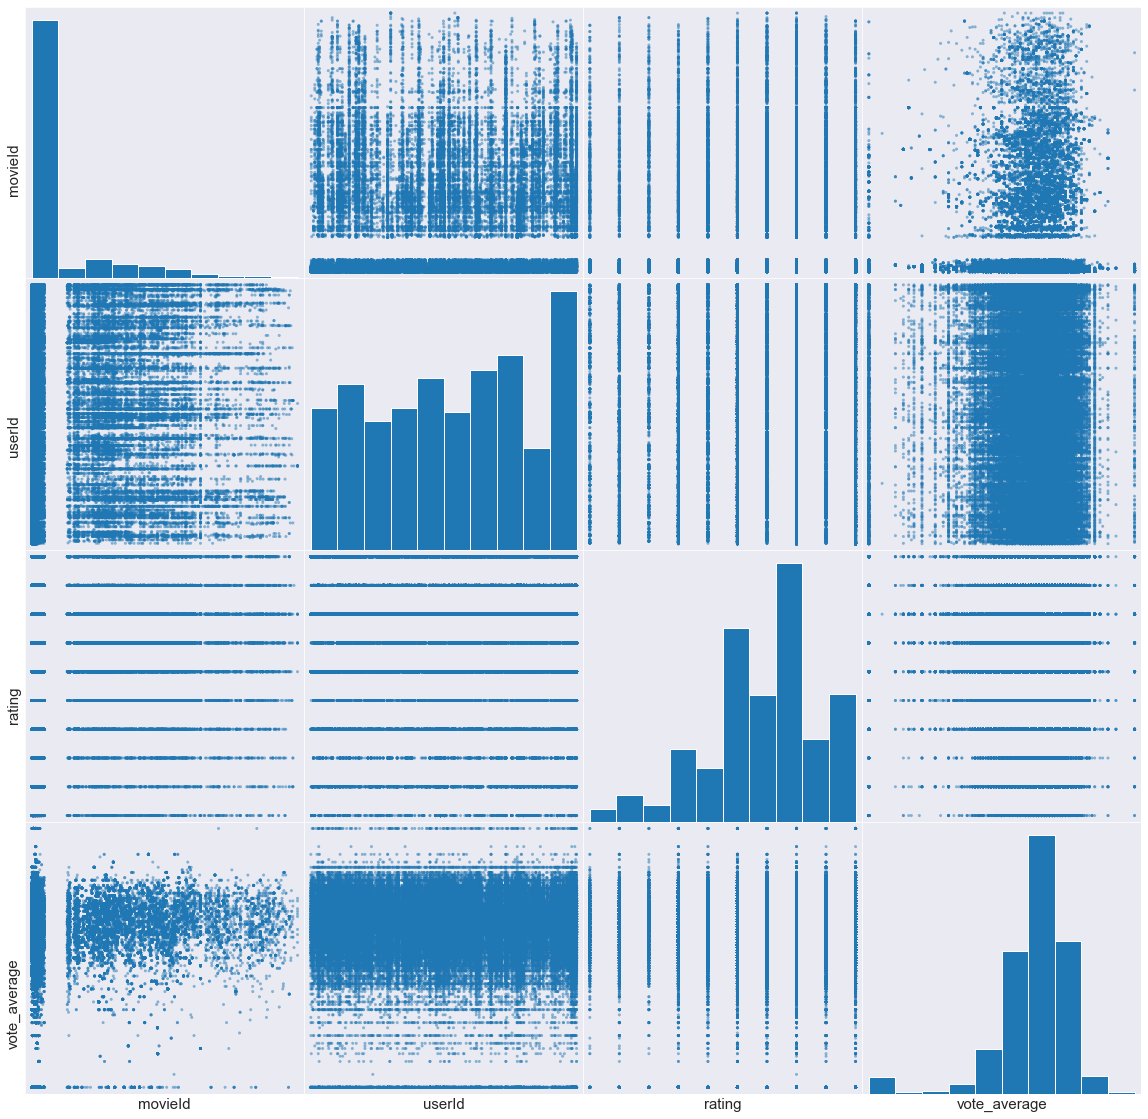

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
sns.set_style('dark')
%matplotlib inline


numeric_features = [t[0] for t in movie_data.dtypes if (t[1] == 'double') or (t[1] == 'str') ]
movie_data.select(numeric_features).describe().toPandas().transpose()

numeric_data = movie_data.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(20, 20));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_size(15)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_size(15)
    h.set_xticks(())


# Task I.2: Recommendation engine

Build the recommendation model using ALS on the training data

In [5]:
(training,test)=movie_data.randomSplit([0.8, 0.2]) # split into training and testing sets

This subtask requires you to implement a recommender system on Collaborative filtering with Alternative Least Squares Algorithm.

In [6]:
# Build the recommendation model using ALS on the training data
#Fitting the Alternating Least Squares Model

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,regParam=0.09,rank=25,userCol="userId",itemCol="movieId",ratingCol="rating",coldStartStrategy="drop",nonnegative=True)
model = als.fit(training) # fit the ALS model to the training set

Generating Predictions & Model Evaluation:
    Evaluating a model is a core part of building an effective machine learning model. In PySpark we will be using 
    RMSE(Root mean squared Error) as our evaluation metric.
    The RMSE described our error in terms of the rating column.

In [7]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))
predictions.show()

RMSE=0.8822028113183931
+-------+------+------+------------+----------+--------+--------+-----+--------------------+--------------------+----------+
|movieId|userId|rating|vote_average|vote_count| revenue|  budget|adult|               title|              genres|prediction|
+-------+------+------+------------+----------+--------+--------+-----+--------------------+--------------------+----------+
|  471.0| 133.0|   4.0|         5.1|        42|21011500|17080000|FALSE|Hudsucker Proxy, ...|              Comedy| 3.1945283|
|  471.0| 597.0|   2.0|         5.1|        42|21011500|17080000|FALSE|Hudsucker Proxy, ...|              Comedy| 4.0743723|
|  471.0| 372.0|   3.0|         5.1|        42|21011500|17080000|FALSE|Hudsucker Proxy, ...|              Comedy| 3.2968726|
|  471.0| 599.0|   2.5|         5.1|        42|21011500|17080000|FALSE|Hudsucker Proxy, ...|              Comedy|  2.610811|
|  471.0| 387.0|   3.0|         5.1|        42|21011500|17080000|FALSE|Hudsucker Proxy, ...|         

Recommending Movies with ALS:
    The approach here will be simple We will be taking a single userid example 29 as features and pass it to trained ALS Model.
    The same way we did with the test data!


In [8]:
single_user = test.filter(test['userId']==29).select(['movieId','userId','title','genres'])
# User had 10 ratings in the test data set 
# Realistically this should be some sort of hold out set!
single_user.show()

+-------+------+--------------------+--------------------+
|movieId|userId|               title|              genres|
+-------+------+--------------------+--------------------+
|  150.0|  29.0|    Apollo 13 (1995)|Adventure|Drama|IMAX|
|  165.0|  29.0|Die Hard: With a ...|Action|Crime|Thri...|
|  170.0|  29.0|      Hackers (1995)|Action|Adventure|...|
|  316.0|  29.0|     Stargate (1994)|Action|Adventure|...|
|  750.0|  29.0|Dr. Strangelove o...|          Comedy|War|
|  904.0|  29.0|  Rear Window (1954)|    Mystery|Thriller|
|  914.0|  29.0| My Fair Lady (1964)|Comedy|Drama|Musi...|
| 1204.0|  29.0|Lawrence of Arabi...| Adventure|Drama|War|
| 1213.0|  29.0|   Goodfellas (1990)|         Crime|Drama|
| 1224.0|  29.0|      Henry V (1989)|Action|Drama|Roma...|
| 1303.0|  29.0|Man Who Would Be ...|     Adventure|Drama|
| 1617.0|  29.0|L.A. Confidential...|Crime|Film-Noir|M...|
| 1792.0|  29.0|U.S. Marshals (1998)|Action|Crime|Thri...|
| 1939.0|  29.0|Best Years of Our...|           Drama|Wa

In [9]:
#Now we will use model.transform() function in order to generate recommended movies along with their predicted features.

recomendations = model.transform(single_user)
recomendations.orderBy('prediction',ascending=False).show()

+-------+------+--------------------+--------------------+----------+
|movieId|userId|               title|              genres|prediction|
+-------+------+--------------------+--------------------+----------+
| 1204.0|  29.0|Lawrence of Arabi...| Adventure|Drama|War| 4.6565285|
|  750.0|  29.0|Dr. Strangelove o...|          Comedy|War| 4.5187373|
|  904.0|  29.0|  Rear Window (1954)|    Mystery|Thriller|  4.429528|
| 1213.0|  29.0|   Goodfellas (1990)|         Crime|Drama|  4.413741|
| 2028.0|  29.0|Saving Private Ry...|    Action|Drama|War| 4.3945866|
| 1303.0|  29.0|Man Who Would Be ...|     Adventure|Drama| 4.3114443|
| 1939.0|  29.0|Best Years of Our...|           Drama|War| 4.2867856|
| 5995.0|  29.0| Pianist, The (2002)|           Drama|War|  4.277827|
| 7156.0|  29.0|Fog of War: Eleve...|     Documentary|War| 4.2490253|
| 5010.0|  29.0|Black Hawk Down (...|    Action|Drama|War| 4.1759233|
| 1617.0|  29.0|L.A. Confidential...|Crime|Film-Noir|M...|  4.141288|
|26729.0|  29.0|Hear

# Task I.3: Classification

This subtask requires you to implement a classification system with Logistic regression. You need to include

Building a classification model using Logistic Regression (LR)

In [10]:
from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=['vote_average','vote_count', 'revenue','budget'],outputCols=['vote_average','vote_count', 'revenue','budget'])
model=imputer.fit(movie_data)
movie_data=model.transform(movie_data)
movie_data.show(5)

+-------+------+------+------------+----------+---------+--------+-----+--------------------+--------------------+
|movieId|userId|rating|vote_average|vote_count|  revenue|  budget|adult|               title|              genres|
+-------+------+------+------------+----------+---------+--------+-----+--------------------+--------------------+
|    1.0|   1.0|   4.0|         7.7|      5415|373554033|30000000|FALSE|    Toy Story (1995)|Adventure|Animati...|
|    3.0|   1.0|   4.0|         6.5|        92|        0|       0|FALSE|Grumpier Old Men ...|      Comedy|Romance|
|    6.0|   1.0|   4.0|         7.7|      1886|187436818|60000000|FALSE|         Heat (1995)|Action|Crime|Thri...|
|   47.0|   1.0|   5.0|         5.4|       452|122195920|18000000|FALSE|Seven (a.k.a. Se7...|    Mystery|Thriller|
|   50.0|   1.0|   5.0|         8.1|      5915|327311859|33000000|FALSE|Usual Suspects, T...|Crime|Mystery|Thr...|
+-------+------+------+------------+----------+---------+--------+-----+--------

In [11]:
cols=movie_data.columns
cols.remove("userId")
cols.remove("movieId")
cols.remove("title")
cols.remove("genres")
cols.remove("adult")

from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = cols, outputCol = "features")

# Now let us use the transform method to transform our dataset
movie_data = vectorAssembler.transform(movie_data)




In [12]:
#Randomly split data into train and test sets, and set seed for reproducibility.

(training,test)=movie_data.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(training.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 80792
Test Dataset Count: 20044


Logistic Regression Model

In [13]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'userId', maxIter=10)
lrModel = lr.fit(training)

Make predictions on the test set.

In [14]:
predict_train=lrModel.transform(training)
predict_test=lrModel.transform(test)
predict_test.select("userId", "prediction").show(10)

+------+----------+
|userId|prediction|
+------+----------+
|   1.0|     603.0|
|  27.0|     294.0|
|  33.0|     294.0|
|  40.0|     603.0|
|  46.0|     603.0|
|  57.0|     603.0|
|  68.0|     294.0|
|  89.0|     294.0|
|  91.0|     603.0|
|  93.0|     294.0|
+------+----------+
only showing top 10 rows



Evaluate our Logistic Regression Model

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='userId')
predict_test.select("userId","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+------+--------------------+----------+--------------------+
|userId|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|   1.0|[-4.3539941842314...|     603.0|[1.20837400355320...|
|  27.0|[-4.3451377886585...|     294.0|[1.13916436063618...|
|  33.0|[-4.3451377886585...|     294.0|[1.13916436063618...|
|  40.0|[-4.3628505798043...|     603.0|[1.23724613854051...|
|  46.0|[-4.3628505798043...|     603.0|[1.23724613854051...|
+------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 1.0
The area under ROC for test set is 1.0
